In [122]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
# import glob2 as glob
import matplotlib as mpl
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import pickle
from scipy.stats import linregress
from aux_funcs import compressed_read, format_plot
from copy import deepcopy as copy
from nb_analysis_tools import *
from scipy.stats import beta
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler

plt.rcParams['font.family'] = 'Helvetica Light'

color_high_reward = '#d95f02'
color_low_reward = '#1b9e77'
color_unrewarded = '#7570b3'
color_intersite = '#808080'
color_interpatch = '#b3b3b3'

odor_colors = [
    color_unrewarded,
    color_low_reward,
    color_high_reward,
]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def clopper_pearson(k, n, alpha=0.05):
    lower = np.where(k == 0, 0, beta.ppf(alpha / 2, k, n - k + 1))
    upper = np.where(k == n, 1., beta.ppf(1 - alpha / 2, k + 1, n - k))
    return np.stack([lower, upper])

In [24]:
def plot_session(data_path, env_idx, update_num=None, xlim=None, max_reward_param=30, max_reward_sites=8):

    b_data_raw = load_behavioral_data(data_path, update_num).__next__()
    b_data = parse_behavioral_data(b_data_raw, env_idx)
    ss = get_session_summaries([b_data])[0]

    rewards_at_positions = b_data['rewards_at_positions']
    reward_attempted_at_positions = b_data['reward_attempted_at_positions']
    all_patch_nums = b_data['current_patch_num']
    all_patch_reward_params = b_data['patch_reward_param']
    rewards_seen_in_patch = b_data['rewards_seen_in_patch']
              
    scale = 0.8
    fig, axs = plt.subplots(1, 1, figsize=(10 * scale, 3 * scale))

    axs.plot(np.arange(len(b_data['dwell_times_at_positions'])), 1/np.array(b_data['dwell_times_at_positions']), c='black', zorder=0)
    axs.scatter(np.arange(len(rewards_at_positions))[rewards_at_positions > 0], rewards_at_positions[rewards_at_positions > 0] * 2, c='blue', marker='*')
    axs.scatter(np.arange(len(reward_attempted_at_positions))[reward_attempted_at_positions > 0], reward_attempted_at_positions[reward_attempted_at_positions > 0] * 2.5, c='black', marker='s', s=3)

    cmap = mpl.colormaps['magma']
    
    s_0 = 1.1
    s_1 = 1.75
    last_pstart = None
    pb = None
    last_reward_site_start = None
    last_reward_site_end = None
    reward_site_start = None
    last_odor_site_data = None
    patch_count = 0
    rw_site_counter = 0
    plotted_cnt = 0

    for i, pstart in enumerate(b_data['current_patch_start']):
        # print(f'Step {i}')
        if last_pstart is None or (pstart != last_pstart).any(): # This is a new patch
            patch_count += 1
            pb = [pstart, pstart]
            c = odor_colors[all_patch_nums[i]]
            rw_site_counter = 0
        
        rwsb = copy(b_data['reward_bounds'][i])
        reward_site_start = int(rwsb[0])
        # print('rwsite_start', reward_site_start)
        # print('last_rwsite_start', last_reward_site_start)
        if last_reward_site_start is None or not np.isclose(last_reward_site_start, reward_site_start): # this is a new reward site
            
            axs.fill_between(list(rwsb), s_0 * np.ones(2), y2=s_1 * np.ones(2), alpha=0.5, color=c, zorder=-1)
            axs.fill_between(list(rwsb), np.zeros(2), y2=s_0 * np.ones(2), alpha=0.2, color=c, zorder=-1)
            
            if np.sum(reward_attempted_at_positions[int(rwsb[0]):int(rwsb[1])]) == 0: # site not attempted
                pb[1] = rwsb[1]
                axs.fill_between(pb, s_0 * np.ones(2), s_1 * np.ones(2), alpha=0.2, color=c, zorder=-2)
                axs.fill_between(pb, np.zeros(2), s_0 * np.ones(2), alpha=0.05, color=c, zorder=-2)
            else: # site attempted
                rw_site_counter += 1
        
        last_pstart = pstart
        last_reward_site_start = reward_site_start
        last_reward_site_end = rwsb[1]

    if xlim is not None:
        axs.set_xlim(xlim[0], xlim[1])
    axs.set_ylim(0)
    axs.set_ylabel('Avg. running speed')
    axs.set_xlabel('Position')
    axs.set_yticks([0, 1])
    format_plot(axs, axislabelsize=13, ticklabelsize=12, leftspine=False)
    fig.tight_layout()
    fig.savefig('../../results/figures/raw_behavioral_trace.png')

    labels = [
        'Unrewarded',
        'Low reward',
        'High reward',
    ]
    
    scale = 1.5
    fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)
    # mx = site_stops_for_patch_type.max()
    x = np.arange(ss['site_stops_for_patch_type'].shape[1])
    for k in range(ss['site_stops_for_patch_type'].shape[0]):
        c = odor_colors[k]
        cis = clopper_pearson(ss['site_stops_for_patch_type'][k, :], ss['site_stop_opportunities_for_patch_type'][k, 0])
        axs[k].fill_between(x, cis[0, :], cis[1, :], color=c, alpha=0.2)
        axs[k].plot(x, ss['site_stops_for_patch_type'][k, :] / ss['site_stop_opportunities_for_patch_type'][k, 0], color=c, label=labels[k])
        axs[k].set_ylim(0, 1.1)
    axs[1].set_ylabel('Fraction attempted')
    axs[2].set_xlabel('Reward site number in patch')
    fig.legend()
    format_plot(axs, axislabelsize=13, ticklabelsize=12)
    fig.tight_layout()
    fig.savefig('../../results/figures/behavioral_stops_stats_rws_frac_given_entered.png')

    scale = 1.5
    fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)
    # mx = site_stops_for_patch_type.max()
    x = np.arange(ss['site_stops_for_patch_type'].shape[1])
    for k in range(ss['site_stops_for_patch_type'].shape[0]):
        c = odor_colors[k]
        ss['site_stop_opportunities_for_patch_type'][k, :] = np.where(ss['site_stop_opportunities_for_patch_type'][k, :] == 0, np.nan, ss['site_stop_opportunities_for_patch_type'][k, :])
        cis = clopper_pearson(ss['site_stops_for_patch_type'][k, :], ss['site_stop_opportunities_for_patch_type'][k, :])
        axs[k].fill_between(x, cis[0, :], cis[1, :], color=c, alpha=0.2)
        axs[k].plot(x, ss['site_stops_for_patch_type'][k, :] / ss['site_stop_opportunities_for_patch_type'][k, :], color=c, label=labels[k])
        axs[k].set_ylim(0, 1.1)
    axs[1].set_ylabel('Fraction attempted')
    axs[2].set_xlabel('Reward site number in patch')
    fig.legend()
    format_plot(axs, axislabelsize=13, ticklabelsize=12)
    fig.tight_layout()
    fig.savefig('../../results/figures/behavioral_stops_stats_rws_frac_given_site.svg')
    fig.savefig('../../results/figures/behavioral_stops_stats_rws_frac_given_site.png')

    scale = 1.5
    fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)
    x = np.arange(ss['site_stops_for_patch_type'].shape[1])

    for k in range(ss['site_stops_for_patch_type'].shape[0]):
        c = odor_colors[k]
        pt = k
        if k == 0:
            axs[k].bar(x, ss['site_stop_opportunities_for_patch_type'][pt, :],
                       color='gray', alpha=0.5, label='Sites entered')
        else:
            axs[k].bar(x, ss['site_stop_opportunities_for_patch_type'][pt, :],
                       color='gray', alpha=0.5)
        axs[k].bar(x, ss['site_stops_for_patch_type'][pt, :], color=c, label=labels[k])

    axs[1].set_ylabel('Counts')
    axs[2].set_xlabel('Reward site number in patch')
    fig.legend()
    format_plot(axs, axislabelsize=13, ticklabelsize=12)
    fig.tight_layout()
    fig.savefig('../../results/figures/behavioral_stops_stats_rws_counts.svg')
    fig.savefig('../../results/figures/behavioral_stops_stats_rws_counts.png')

    # Fraction attempted plot
    fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)
    x = np.arange(ss['acc_reward_stops_for_patch_type'].shape[1])

    for k in range(ss['acc_reward_stops_for_patch_type'].shape[0]):
        c = odor_colors[k]
        opp = ss['acc_reward_stop_opportunities_for_patch_type'][k, :]
        runs = ss['acc_reward_stops_for_patch_type'][k, :]
        opp = np.where(opp == 0, np.nan, opp)
        cis = clopper_pearson(runs, opp)
        axs[k].fill_between(x, cis[0, :], cis[1, :], color=c, alpha=0.2)
        axs[k].plot(x, runs / opp, color=c, label=labels[k])
        axs[k].set_ylim(0, 1.1)

    axs[0].set_xlim(-1)
    axs[1].set_ylabel('Fraction attempted')
    axs[2].set_xlabel('Total reward in patch')
    fig.legend()
    format_plot(axs, axislabelsize=13, ticklabelsize=12)
    fig.tight_layout()
    fig.savefig('../../results/figures/behavioral_stops_stats_reward_frac.svg')
    fig.savefig('../../results/figures/behavioral_stops_stats_reward_frac.png')

    # Reward counts plot
    fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)
    x = np.arange(ss['acc_reward_stops_for_patch_type'].shape[1])

    for k in range(ss['acc_reward_stops_for_patch_type'].shape[0]):
        c = odor_colors[k]
        if k == 0:
            axs[k].bar(x, ss['acc_reward_stop_opportunities_for_patch_type'][k, :],
                       color='grey', alpha=0.5, label='Stop opportunities')
        else:
            axs[k].bar(x, ss['acc_reward_stop_opportunities_for_patch_type'][k, :],
                       color='grey', alpha=0.5)
        axs[k].bar(x, ss['acc_reward_stops_for_patch_type'][k, :], color=c, label=labels[k])

    axs[0].set_xlim(-1, max_reward_param)
    axs[1].set_ylabel('Counts')
    axs[2].set_xlabel('Total reward in patch')
    fig.legend()
    format_plot(axs, axislabelsize=13, ticklabelsize=12)
    fig.tight_layout()
    fig.savefig('../../results/figures/behavioral_stops_stats_reward_counts.svg')
    fig.savefig('../../results/figures/behavioral_stops_stats_reward_counts.png')

['00000.pkl', '00050.pkl', '00100.pkl', '00150.pkl', '00200.pkl', '00250.pkl', '00300.pkl', '00350.pkl', '00400.pkl', '00450.pkl', '00500.pkl', '00550.pkl', '00600.pkl', '00650.pkl', '00700.pkl', '00750.pkl', '00800.pkl', '00850.pkl', '00900.pkl', '00950.pkl', '01000.pkl', '01050.pkl', '01100.pkl', '01150.pkl', '01200.pkl', '01250.pkl', '01300.pkl', '01350.pkl', '01400.pkl', '01450.pkl', '01500.pkl', '01550.pkl', '01600.pkl', '01650.pkl', '01700.pkl', '01750.pkl', '01800.pkl', '01850.pkl', '01900.pkl', '01950.pkl', '02000.pkl', '02050.pkl', '02100.pkl', '02150.pkl', '02200.pkl', '02250.pkl', '02300.pkl', '02350.pkl', '02400.pkl', '02450.pkl', '02500.pkl', '02550.pkl', '02600.pkl', '02650.pkl', '02700.pkl', '02750.pkl']
02750.pkl


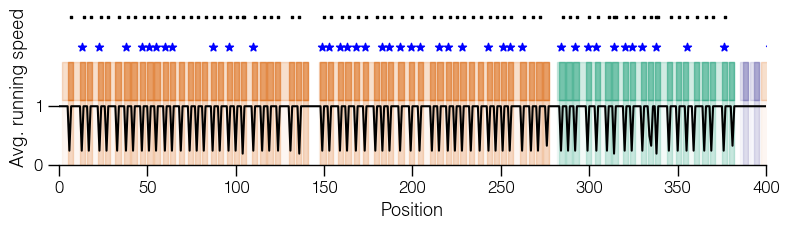

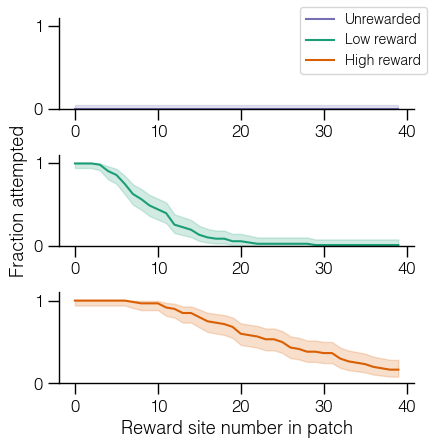

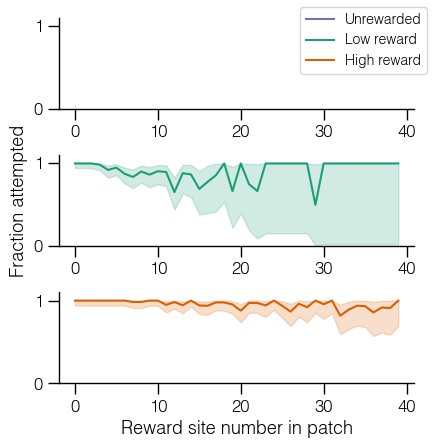

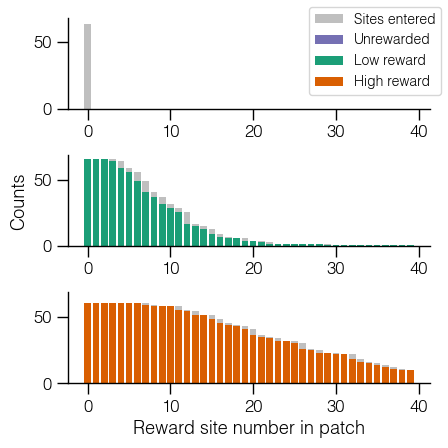

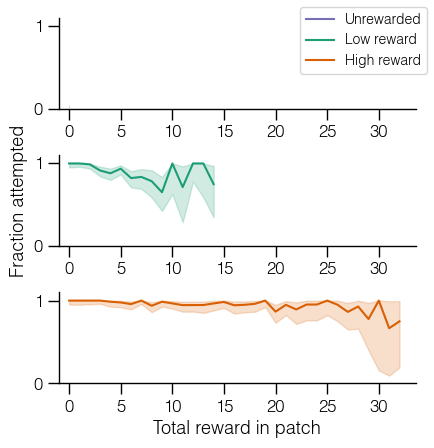

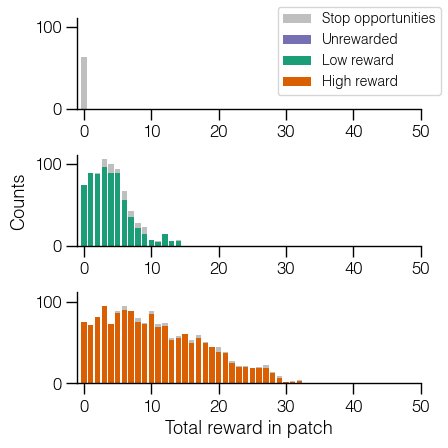

In [25]:
plot_session(
    '../../results/rl_agent_outputs/he_init_vanilla_inoise_0p05_2025-07-06_15_02_35_603284_var_noise_0.0001_activity_weight_1/state',
    env_idx=2,
    xlim=(0, 400),
    max_reward_param=50,
    max_reward_sites=40,
)

In [123]:
def plot_leave_prob_correlations(odor_site_df, predictors):
    results = {}

    scale = 0.5
    fig, axs = plt.subplots(len(predictors), 1, figsize=(scale * 8, scale * 4 * len(predictors)), constrained_layout=True)

    for i, predictor in enumerate(predictors):
        X = odor_site_df[[predictor]].values.reshape(-1, 1)
        y = odor_site_df['stopped'].values.astype(int)

        # Model with class balancing
        model = LogisticRegression()

        # Random undersample to balance classes
        rus = RandomUnderSampler(random_state=42)
        X_resampled, y_resampled = rus.fit_resample(X, y)

        # Define a stratified 5-fold split
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Perform 5-fold cross-validation
        cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=skf, scoring='accuracy')
        avg_accuracy = np.mean(cv_scores)

        # Fit model to entire dataset (so you still get coefficients for reporting)
        model.fit(X, y)
        results[predictor] = model

        print(f"\nLogistic regression for: {predictor}")
        print(f"Average CV Accuracy (5-fold): {avg_accuracy:.4f}")
        print(f"Intercept: {model.intercept_[0]:.4f}, Coef: {model.coef_[0][0]:.4f}")

        # Count stopped = 0 and 1 for each unique value of the predictor
        grouped = odor_site_df.groupby(predictor)['stopped'].value_counts().unstack()

        # Reorder columns to have '1' (stopped) first = bottom of the stack
        if 1 in grouped.columns and 0 in grouped.columns:
            grouped = grouped[[1, 0]]
            colors = ['black', 'lightgray']
        else:
            colors = ['black'] if 1 in grouped.columns else ['lightgray']

        # Plot stacked bar chart
        grouped.plot(kind='bar', stacked=True, ax=axs[i], color=colors)

        axs[i].set_xlabel(predictor.replace('_', ' '), fontsize=11)
        axs[i].set_ylabel('Count', fontsize=11)

        if predictor == 'index':
            axs[i].set_xticks([0, 40])

        # Convert xtick labels to ints if possible
        xticks = axs[i].get_xticks()
        xticklabels = []
        for tick in axs[i].get_xticklabels():
            try:
                xticklabels.append(int(float(tick.get_text())))
            except:
                xticklabels.append(tick.get_text())
        axs[i].set_xticks(xticks)
        axs[i].set_xticklabels(xticklabels)

    format_plot(axs)  # If you have your own formatting function

    plt.show()

    return results

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
00007.pkl


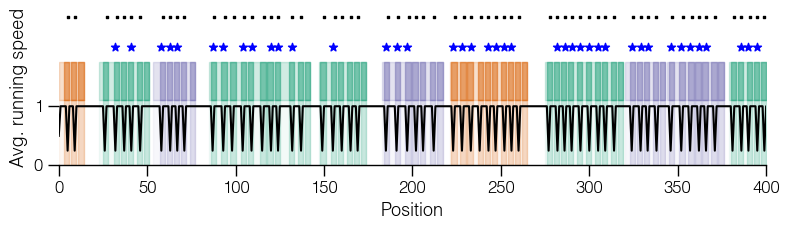

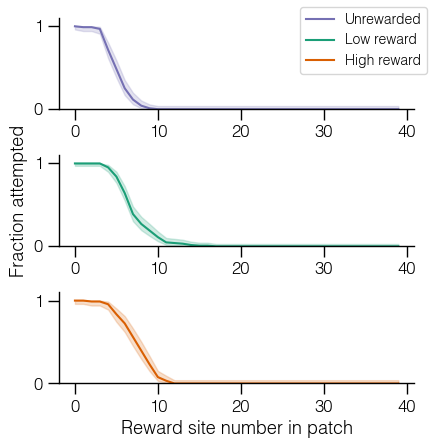

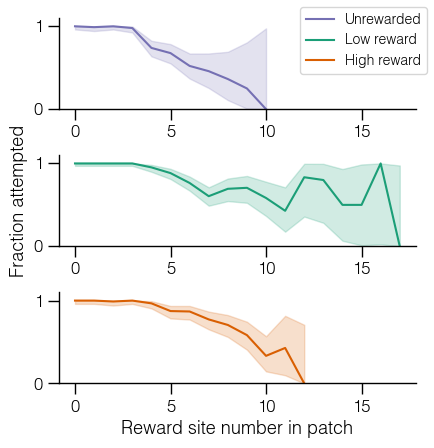

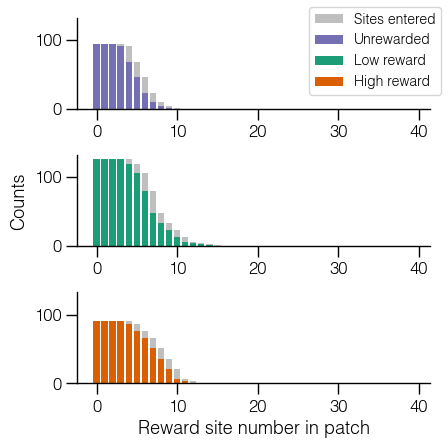

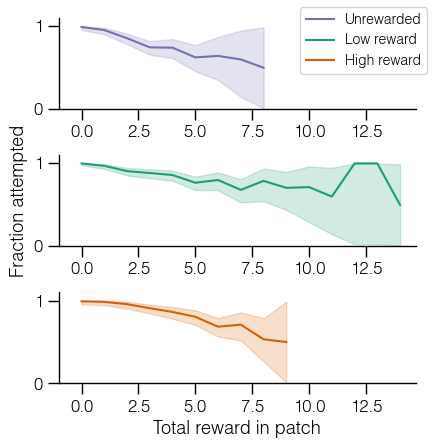

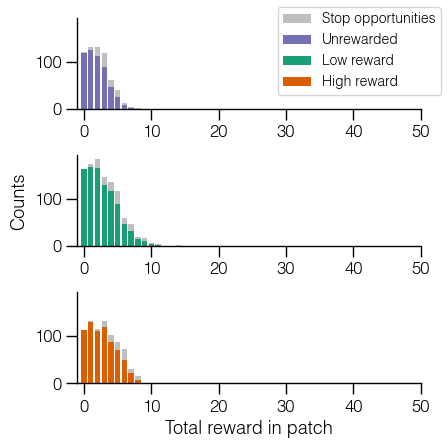

In [87]:
plot_session(
    '../../results/rl_agent_outputs/he_init_vanilla_indep_test_2025-07-31_17_28_09_615835_var_noise_0.0_activity_weight_1/state',
    env_idx=3,
    xlim=(0, 400),
    max_reward_param=50,
    max_reward_sites=40,
)

In [49]:
all_session_data_indep = get_all_session_summaries(
    '../../results/rl_agent_outputs/he_init_vanilla_indep_test_2025-07-31_17_28_09_615835_var_noise_0.0_activity_weight_1',
)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
00000.pkl
00001.pkl
00002.pkl
00003.pkl
00004.pkl
00005.pkl
00006.pkl
00007.pkl
Session data loaded
Session summaries generated


In [75]:
indep_df = pd.concat([odor_site_df for ss in all_session_data_indep for odor_site_df in ss['all_odor_site_data']])
print(indep_df)

    dist_last_odor_site  patch_reward_param  index  stopped  rewarded  \
0                   NaN           19.891437      0        1         0   
0                   2.0           19.891437      1        1         0   
0                   2.0           19.891437      2        1         1   
0                   2.0           19.891437      3        1         1   
0                   1.0           19.891437      4        1         1   
..                  ...                 ...    ...      ...       ...   
0                   2.0            4.736117      9        0         1   
0                   NaN           27.721053      0        1         0   
0                   3.0           27.721053      1        1         1   
0                   1.0           27.721053      2        1         1   
0                   3.0           27.721053      3        1         1   

    rewarded_last_odor_site  added  rewards_seen_in_patch  
0                         0      1                      0  
0  


Logistic regression for: rewarded_last_odor_site
Average CV Accuracy (5-fold): 0.8713
Intercept: 0.4473, Coef: 6.1725

Logistic regression for: dist_last_odor_site
Average CV Accuracy (5-fold): 0.5302
Intercept: 1.4208, Coef: 0.2452

Logistic regression for: rewards_seen_in_patch
Average CV Accuracy (5-fold): 0.6419
Intercept: 2.7666, Coef: -0.2481

Logistic regression for: index
Average CV Accuracy (5-fold): 0.7398
Intercept: 3.9281, Coef: -0.3844

Logistic regression for: added
Average CV Accuracy (5-fold): 0.5000
Intercept: 0.9113, Coef: 0.9113


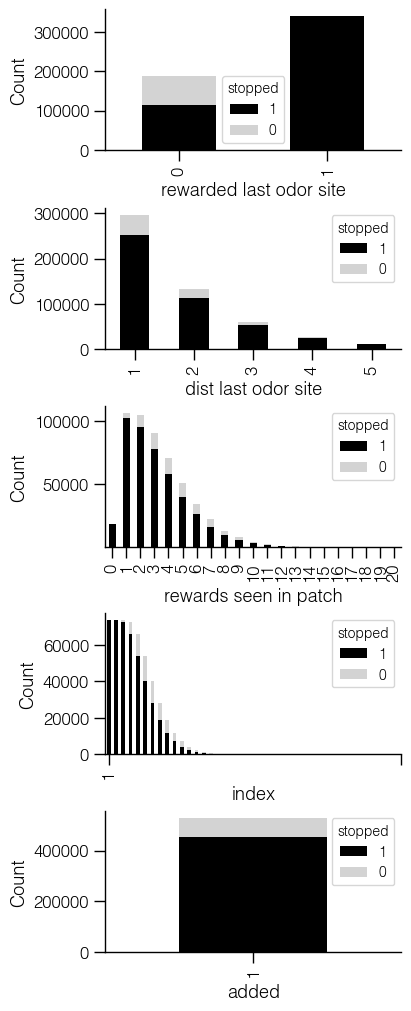

{'rewarded_last_odor_site': LogisticRegression(),
 'dist_last_odor_site': LogisticRegression(),
 'rewards_seen_in_patch': LogisticRegression(),
 'index': LogisticRegression(),
 'added': LogisticRegression()}

In [124]:
plot_leave_prob_correlations(
    indep_df[indep_df['index'] > 0],
    ['rewarded_last_odor_site', 'dist_last_odor_site', 'rewards_seen_in_patch', 'index', 'added']
)

In [70]:
all_session_data_fixed = get_all_session_summaries(
    '../../results/rl_agent_outputs/he_init_vanilla_fixed_813001_rw_size_1_test_2025-08-07_10_45_13_260304_var_noise_0.0_activity_weight_1',
)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
00000.pkl
00001.pkl
00002.pkl
00003.pkl
00004.pkl
00005.pkl
00006.pkl
00007.pkl
Session data loaded
Session summaries generated


In [71]:
fixed_df = pd.concat([odor_site_df for ss in all_session_data_fixed for odor_site_df in ss['all_odor_site_data']])
print(fixed_df)

    dist_last_odor_site  patch_reward_param  index  stopped  rewarded  \
0                   NaN                 0.0      0        0         1   
0                   NaN                10.0      0        1         1   
0                   2.0                10.0      1        1         1   
0                   2.0                10.0      2        1         1   
0                   1.0                10.0      3        1         0   
..                  ...                 ...    ...      ...       ...   
0                   2.0                30.0      6        1         1   
0                   1.0                30.0      7        1         1   
0                   1.0                30.0      8        1         1   
0                   1.0                30.0      9        1         1   
0                   4.0                30.0     10        1         0   

    rewarded_last_odor_site  added  rewards_seen_in_patch  
0                         0      1                      0  
0  


Logistic regression for: rewarded_last_odor_site
Average CV Accuracy (5-fold): 0.7046
Intercept: 1.2613, Coef: 1.7426

Logistic regression for: dist_last_odor_site
Average CV Accuracy (5-fold): 0.7100
Intercept: -0.5463, Coef: 2.1103

Logistic regression for: rewards_seen_in_patch
Average CV Accuracy (5-fold): 0.5315
Intercept: 2.6251, Coef: -0.0816


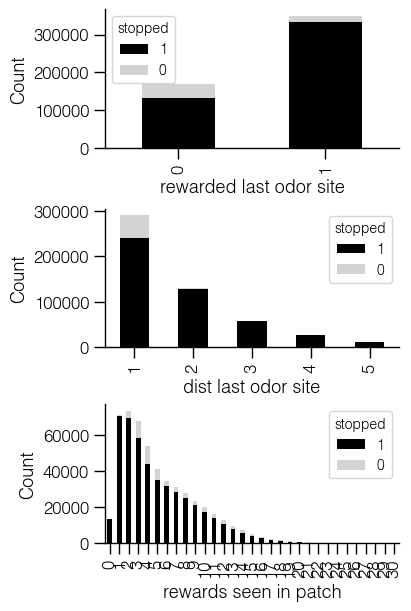

{'rewarded_last_odor_site': LogisticRegression(),
 'dist_last_odor_site': LogisticRegression(),
 'rewards_seen_in_patch': LogisticRegression()}

In [125]:
plot_leave_prob_correlations(
    fixed_df[fixed_df['index'] > 0],
    ['rewarded_last_odor_site', 'dist_last_odor_site', 'rewards_seen_in_patch']
)

In [159]:
def plot_avg_stops_vs_reward_param(data_paths, update_num=None, max_reward_param=10, max_reward_sites=30, model_colors=None):

    cmap = sns.color_palette('rocket', as_cmap=True)
    if model_colors is None:
        model_colors = ['purple', 'green']

    scale = 1
    fig_sensitivity, axs_sensitivity = plt.subplots(6, 5, figsize=(8 * scale, 6 * scale), sharex=True, sharey=True)

    for idx_data_path, data_path in enumerate(data_paths):

        d = load_behavioral_data(data_path, update_num).__next__()
    
        for env_idx in range(30):
            b_data = parse_behavioral_data(d, env_idx)
            rewards_at_positions = b_data['rewards_at_positions']
            reward_attempted_at_positions = b_data['reward_attempted_at_positions']
            all_patch_nums = b_data['current_patch_num']
            all_patch_reward_params = b_data['patch_reward_param']Rna
            
            reward_param_of_stop = []
            site_idx_of_stop =  []
            site_stops_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1, max_reward_sites))
            patches_entered_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1,))
            reward_param_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1,))
            
            last_pstart = None
            last_reward_site_start = None
            patch_count = 0
            for i, pstart in enumerate(b_data['current_patch_start']):
                # print(f'Step {i}')
                if last_pstart is None or (pstart != last_pstart).any():
                    patches_entered_for_patch_type[all_patch_nums[i]] += 1
                    reward_param_for_patch_type[all_patch_nums[i]] = all_patch_reward_params[i]
                    patch_count += 1
                    pb = [pstart, pstart]
                    rw_site_counter = 0
                
                rwsb = copy(b_data['reward_bounds'][i])
                reward_site_start = int(rwsb[0])
                # print('rwsite_start', reward_site_start)
                # print('last_rwsite_start', last_reward_site_start)
                if last_reward_site_start is None or last_reward_site_start != reward_site_start:
                    if np.sum(reward_attempted_at_positions[int(rwsb[0]):int(rwsb[1])]) == 0:
                        pb[1] = rwsb[1]
                    else:
                        reward_param_of_stop.append(b_data['patch_reward_param'][i])
                        site_idx_of_stop.append(rw_site_counter)
                        if rw_site_counter < max_reward_sites:
                            site_stops_for_patch_type[all_patch_nums[i], rw_site_counter] += 1
                        rw_site_counter += 1
        
                last_pstart = pstart
                last_reward_site_start = reward_site_start
            
            print(reward_param_for_patch_type)
    
            scale = 1
            fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)
            # mx = site_stops_for_patch_type.max()
    
            avg_stops_for_patch_type = np.empty((site_stops_for_patch_type.shape[0],))
            
            x = np.arange(1, site_stops_for_patch_type.shape[1] + 1)
            for k in range(site_stops_for_patch_type.shape[0]):
                cdf = site_stops_for_patch_type[k, :] / patches_entered_for_patch_type[k]
                c = cmap(reward_param_for_patch_type[k] / max_reward_param) if reward_param_for_patch_type[k] > 0 else 'black'
                axs[k].bar(x, cdf, color=c)
                axs[k].set_ylim(0, 1.1)
    
                pdf = cdf - np.concatenate([cdf[1:], np.zeros(1)])
                # axs[k].bar(x, pdf, color=cmap(reward_param_for_patch_type[k] / max_reward_param))
    
                avg_stops_for_patch_type[k] = np.dot(pdf, x)
    
            axs[1].set_ylabel('Fraction attempted')
            axs[2].set_xlabel('Odor site number in patch')
    
            ordering = np.argsort(reward_param_for_patch_type)
    
            axs_sensitivity[int(env_idx / 5), env_idx % 5].plot(reward_param_for_patch_type[ordering], avg_stops_for_patch_type[ordering], c=model_colors[idx_data_path])
            axs_sensitivity[int(env_idx / 5), env_idx % 5].scatter(reward_param_for_patch_type, avg_stops_for_patch_type, c=model_colors[idx_data_path])
        
    axs_sensitivity[0, 0].set_ylim(0)
    axs_sensitivity[0, 0].set_xlim(0, max_reward_param * 1.1)
    axs_sensitivity[1, 0].set_ylabel('Avg number of stops')
    axs_sensitivity[-1, 2].set_xlabel('Reward decay parameter')
            
    

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
00007.pkl
[19.32430608 11.42245469 19.89143716]
[ 8.58161465 28.743167   23.10938797]
[25.76667802 11.18133465 16.65386334]
[ 7.45530382 13.49926263 12.32822409]
[ 1.15685043 23.40301382  2.78111266]
[13.74164845  9.25048821  6.94461135]
[21.85521575 18.04842637 28.56542002]
[28.33489809 13.92294523  5.78385087]
[11.54319359 25.7912354  28.32598907]
[16.40667468 23.93697064 24.6120564 ]
[12.23061084  1.6609812  23.65604632]
[ 7.52770871  1.38287462 20.30448723]
[11.23620357 28.52142919 21.95981825]
[ 3.45163699 18.27199618  4.00172893]
[25.04526446  3.14388313 22.33921445]
[29.6703454  16.48634181  8.44341906]
[23.51497052 19.04501118  7.47129275]
[ 3.40465416 29.23449283 21.86203901]
[ 0.52470813 26.74719802  8.54583502]
[ 9.02893368  7.41185496 27.79005405]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_20824\163301953.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)


[14.83804937  6.84249313  7.66421771]
[20.27194247  1.34136547 10.29911018]
[24.69331022  0.78353945  6.3231192 ]
[25.39987222 16.83496621 13.64626207]
[12.60548901 10.89718491  5.54630063]
[ 2.7932486  29.1496776  14.51579941]
[29.52575552 10.00236798 20.21104874]
[ 2.62048929  6.91431299 12.33183212]
[10.95316749 13.53617748 14.88181046]
[27.72105347  4.73611742 26.0074523 ]


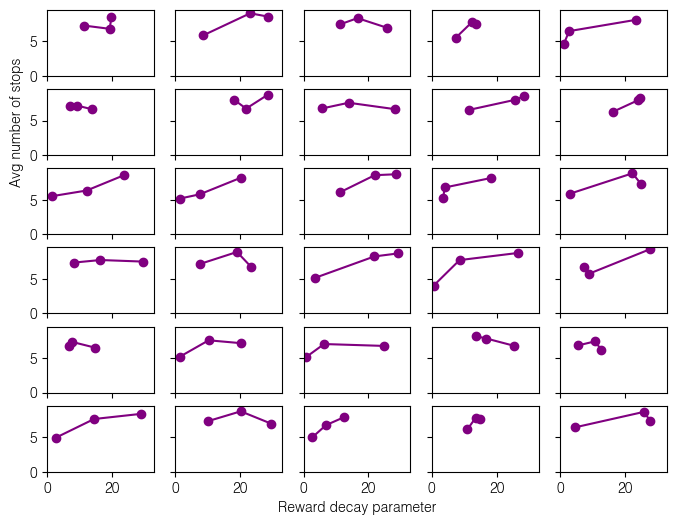

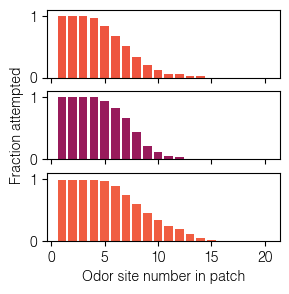

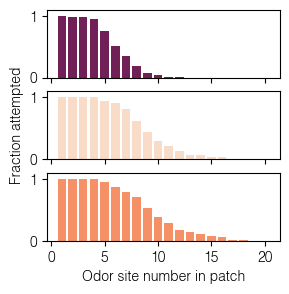

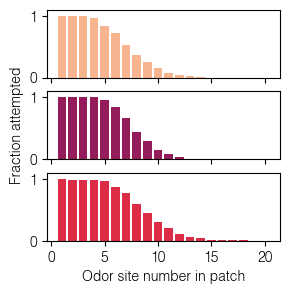

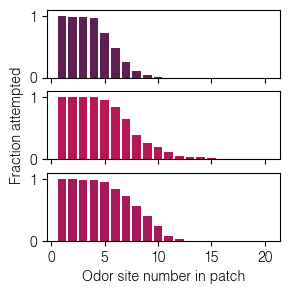

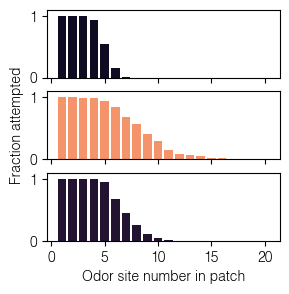

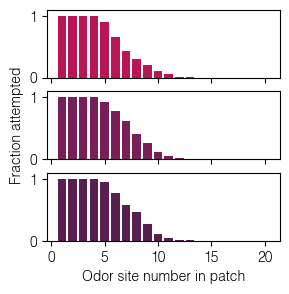

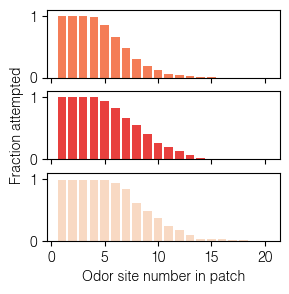

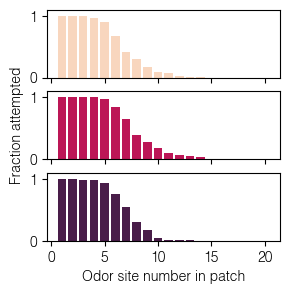

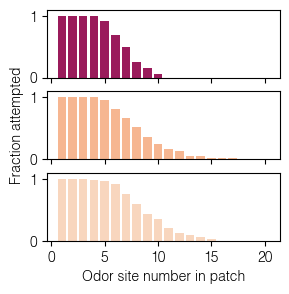

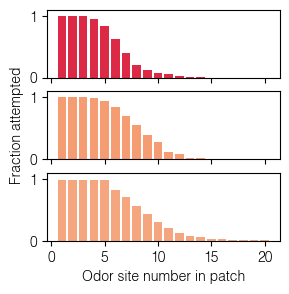

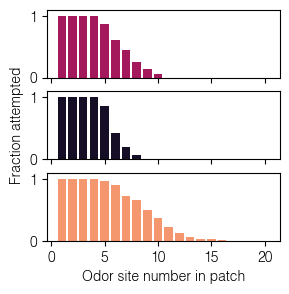

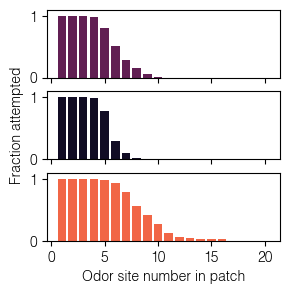

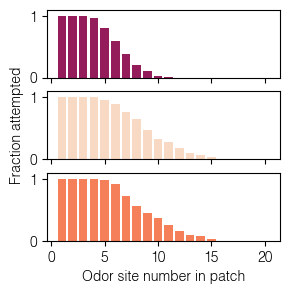

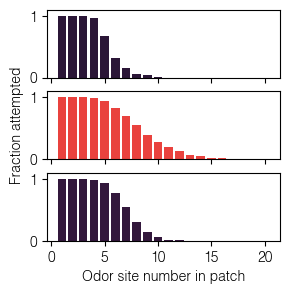

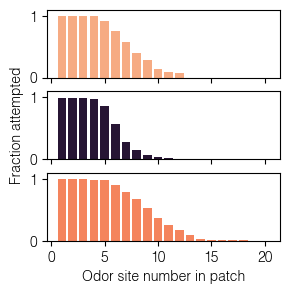

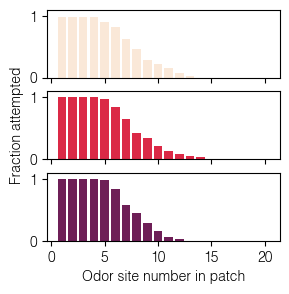

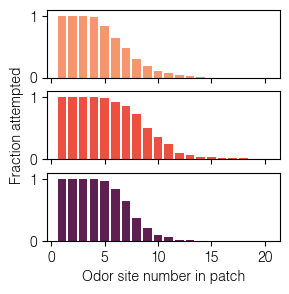

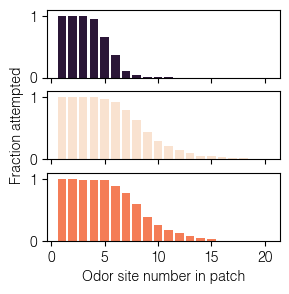

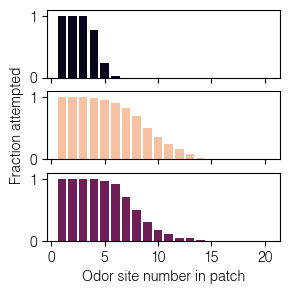

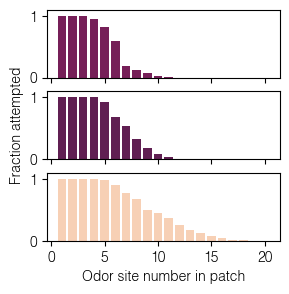

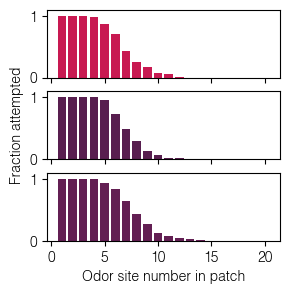

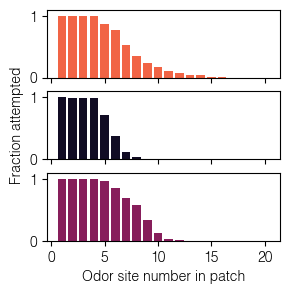

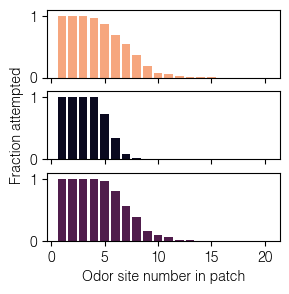

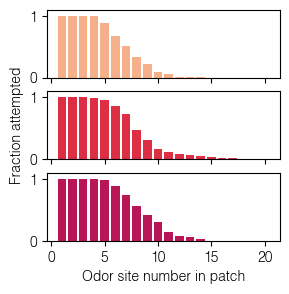

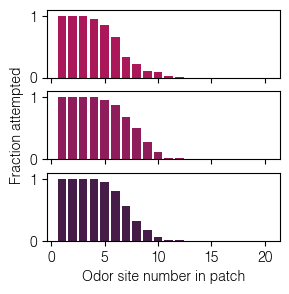

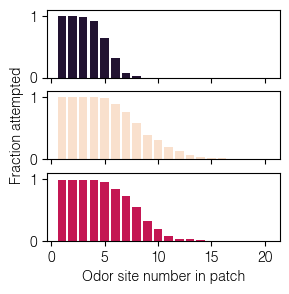

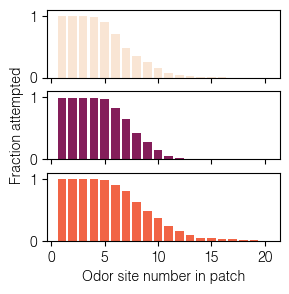

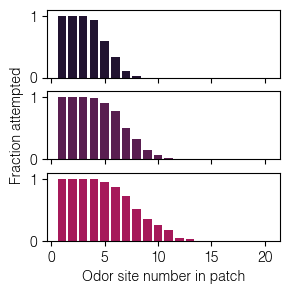

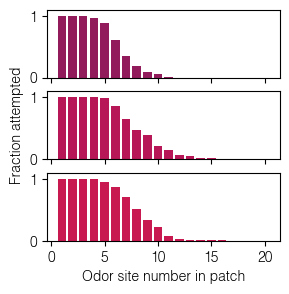

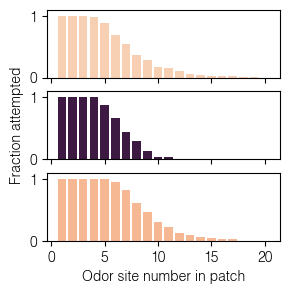

In [160]:
plot_avg_stops_vs_reward_param([
    '../../results/rl_agent_outputs/he_init_vanilla_indep_test_2025-07-31_17_28_09_615835_var_noise_0.0_activity_weight_1/state',
], update_num=None, max_reward_param=30, max_reward_sites=20, model_colors=None)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
00007.pkl
[19.32430608 11.42245469 19.89143716]
[ 8.58161465 28.743167   23.10938797]
[25.76667802 11.18133465 16.65386334]
[ 7.45530382 13.49926263 12.32822409]
[ 1.15685043 23.40301382  2.78111266]
[13.74164845  9.25048821  6.94461135]
[21.85521575 18.04842637 28.56542002]
[28.33489809 13.92294523  5.78385087]
[11.54319359 25.7912354  28.32598907]
[16.40667468 23.93697064 24.6120564 ]
[12.23061084  1.6609812  23.65604632]
[ 7.52770871  1.38287462 20.30448723]
[11.23620357 28.52142919 21.95981825]
[ 3.45163699 18.27199618  4.00172893]
[25.04526446  3.14388313 22.33921445]
[29.6703454  16.48634181  8.44341906]
[23.51497052 19.04501118  7.47129275]
[ 3.40465416 29.23449283 21.86203901]
[ 0.52470813 26.74719802  8.54583502]
[ 9.02893368  7.41185496 27.79005405]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_20824\163301953.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)


[14.83804937  6.84249313  7.66421771]
[20.27194247  1.34136547 10.29911018]
[24.69331022  0.78353945  6.3231192 ]
[25.39987222 16.83496621 13.64626207]
[12.60548901 10.89718491  5.54630063]
[ 2.7932486  29.1496776  14.51579941]
[29.52575552 10.00236798 20.21104874]
[ 2.62048929  6.91431299 12.33183212]
[10.95316749 13.53617748 14.88181046]
[27.72105347  4.73611742 26.0074523 ]


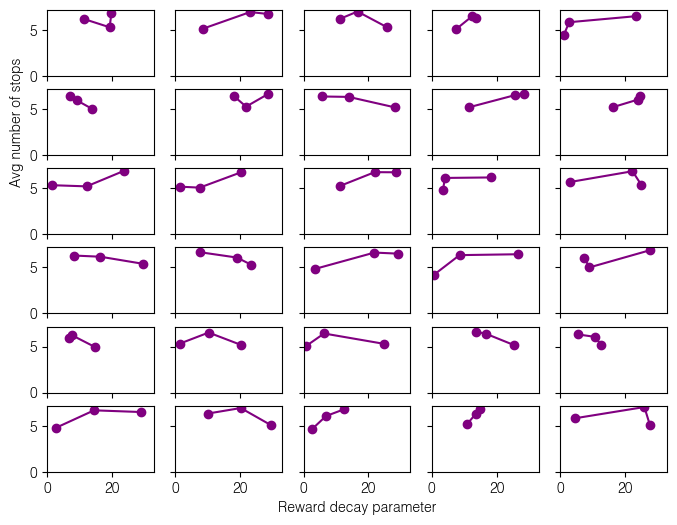

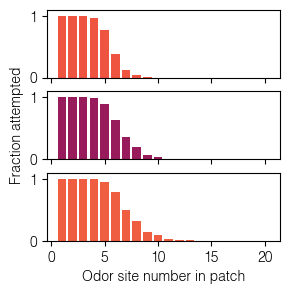

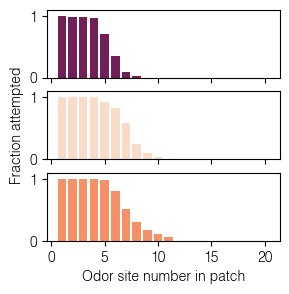

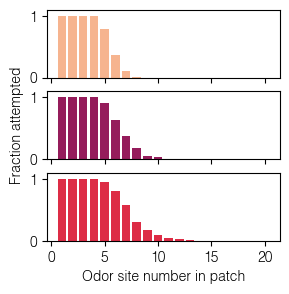

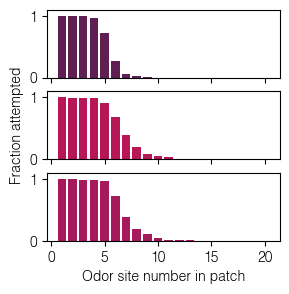

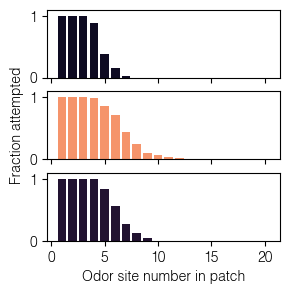

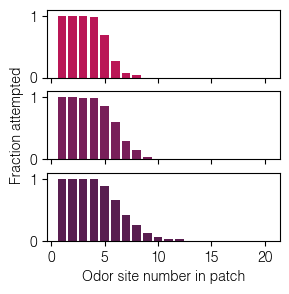

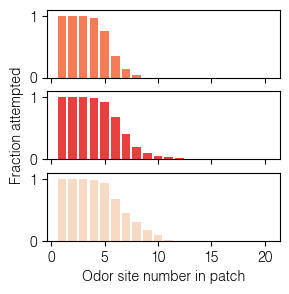

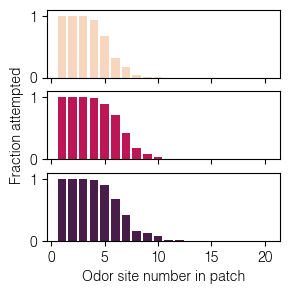

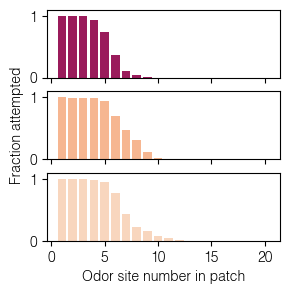

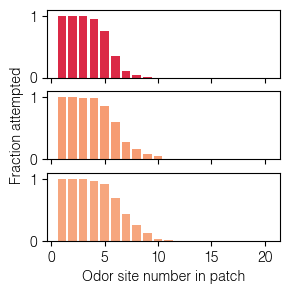

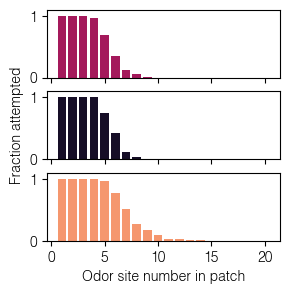

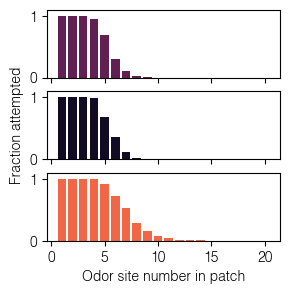

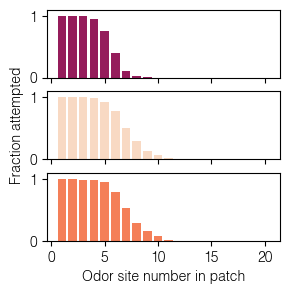

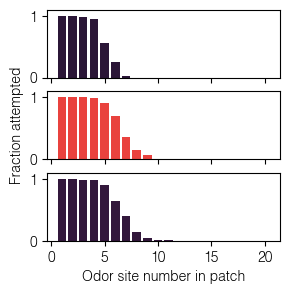

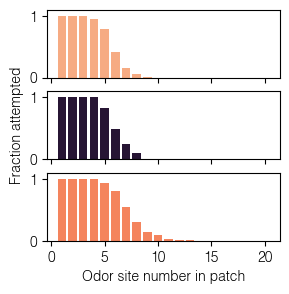

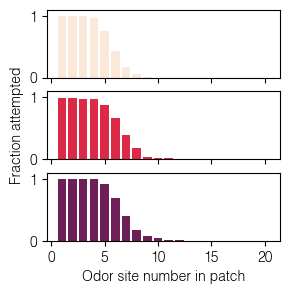

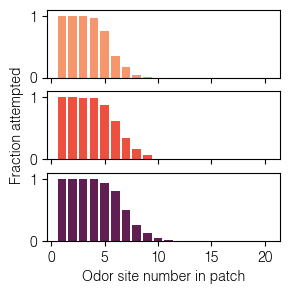

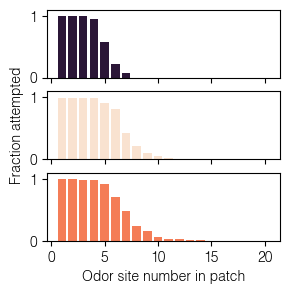

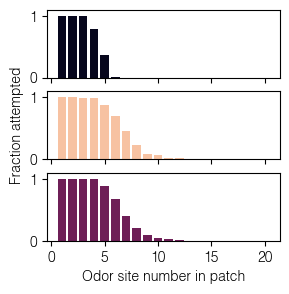

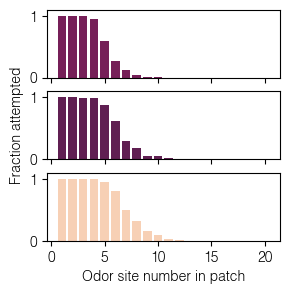

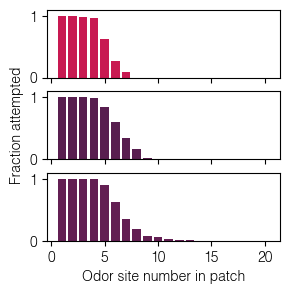

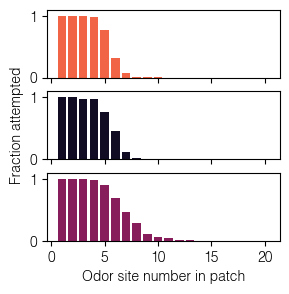

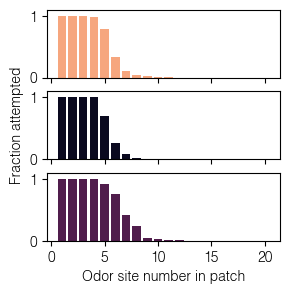

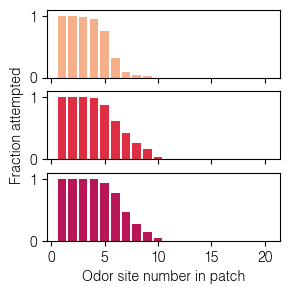

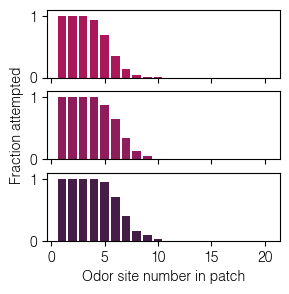

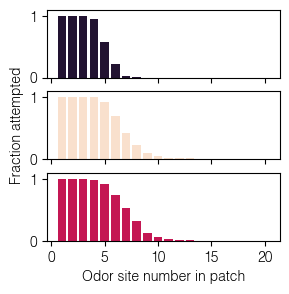

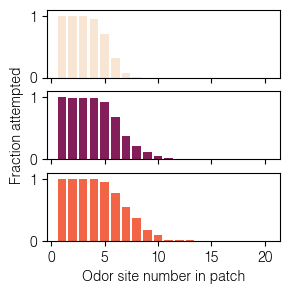

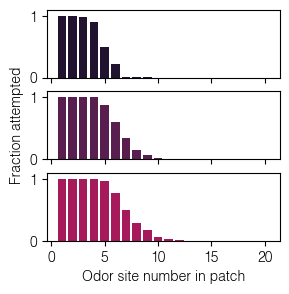

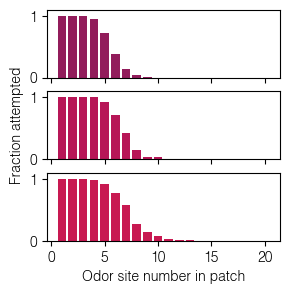

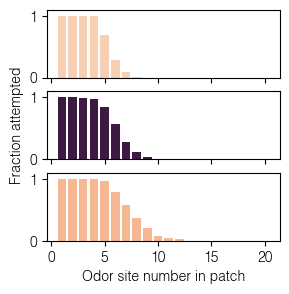

In [161]:
plot_avg_stops_vs_reward_param([
    '../../results/rl_agent_outputs/he_init_vanilla_indep_test_half_reward_2025-07-31_18_04_52_934603_var_noise_0.0_activity_weight_1/state',
], update_num=None, max_reward_param=30, max_reward_sites=20, model_colors=None)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
00007.pkl
[19.32430608 11.42245469 19.89143716]
[ 8.58161465 28.743167   23.10938797]
[25.76667802 11.18133465 16.65386334]
[ 7.45530382 13.49926263 12.32822409]
[ 1.15685043 23.40301382  2.78111266]
[13.74164845  9.25048821  6.94461135]
[21.85521575 18.04842637 28.56542002]
[28.33489809 13.92294523  5.78385087]
[11.54319359 25.7912354  28.32598907]
[16.40667468 23.93697064 24.6120564 ]
[12.23061084  1.6609812  23.65604632]
[ 7.52770871  1.38287462 20.30448723]
[11.23620357 28.52142919 21.95981825]
[ 3.45163699 18.27199618  4.00172893]
[25.04526446  3.14388313 22.33921445]
[29.6703454  16.48634181  8.44341906]
[23.51497052 19.04501118  7.47129275]
[ 3.40465416 29.23449283 21.86203901]
[ 0.52470813 26.74719802  8.54583502]
[ 9.02893368  7.41185496 27.79005405]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_20824\163301953.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)


[14.83804937  6.84249313  7.66421771]
[20.27194247  1.34136547 10.29911018]
[24.69331022  0.78353945  6.3231192 ]
[25.39987222 16.83496621 13.64626207]
[12.60548901 10.89718491  5.54630063]
[ 2.7932486  29.1496776  14.51579941]
[29.52575552 10.00236798 20.21104874]
[ 2.62048929  6.91431299 12.33183212]
[10.95316749 13.53617748 14.88181046]
[27.72105347  4.73611742 26.0074523 ]


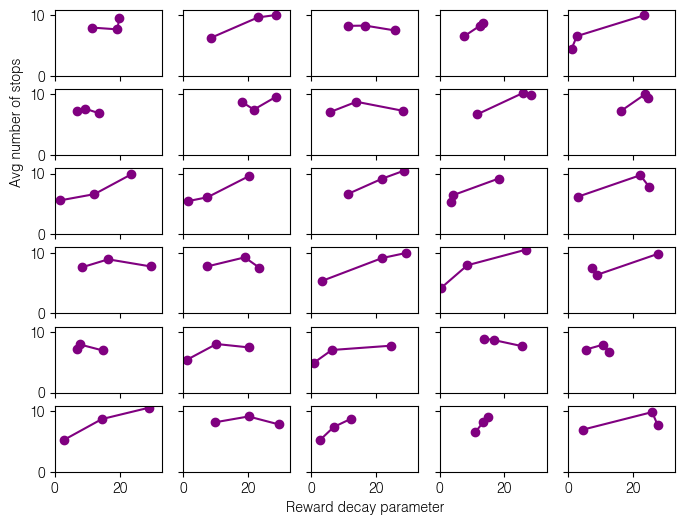

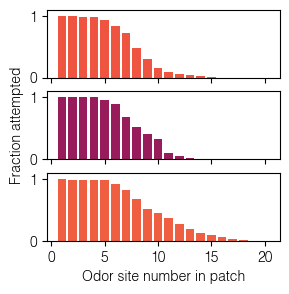

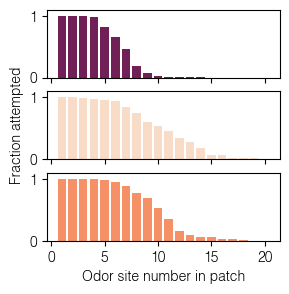

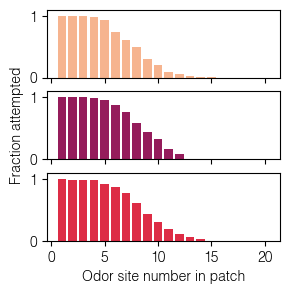

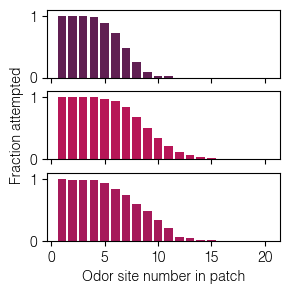

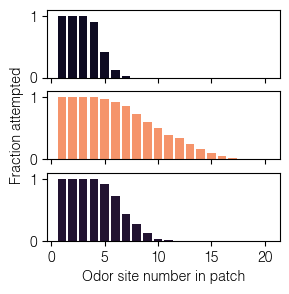

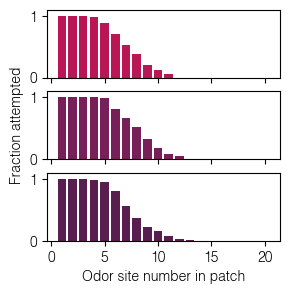

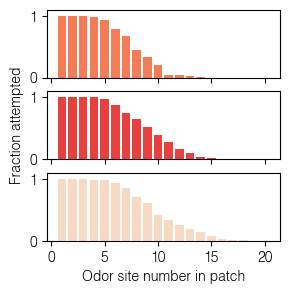

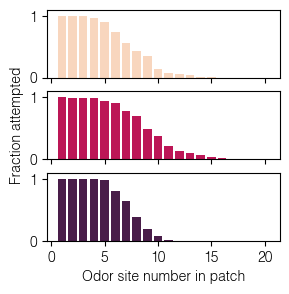

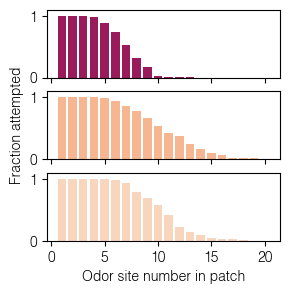

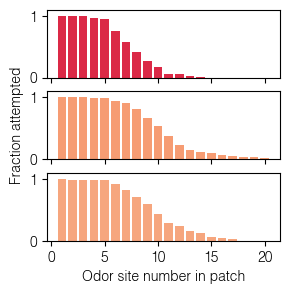

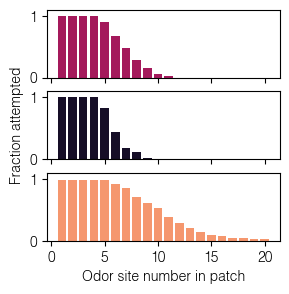

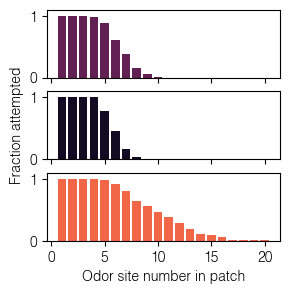

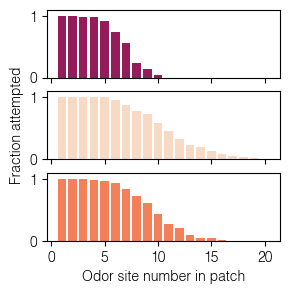

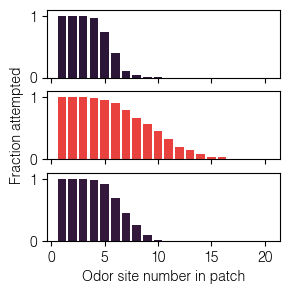

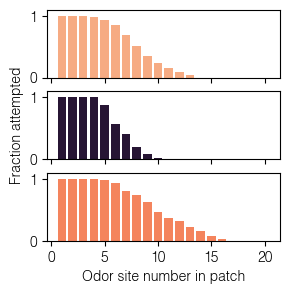

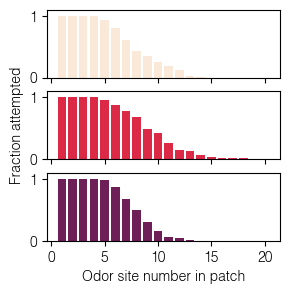

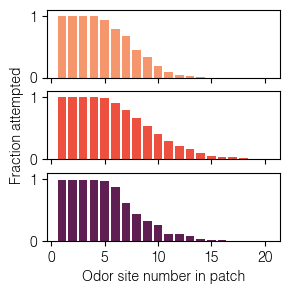

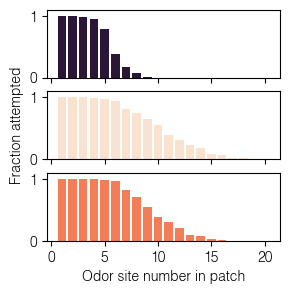

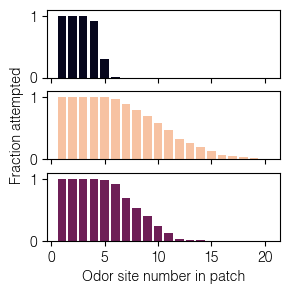

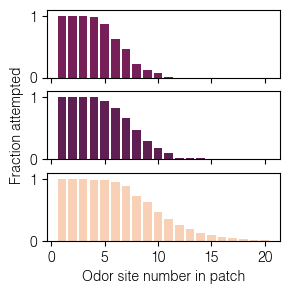

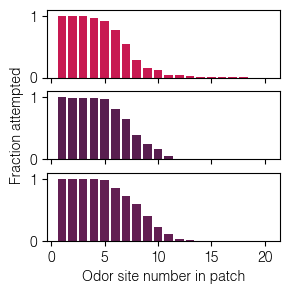

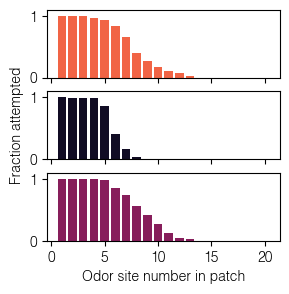

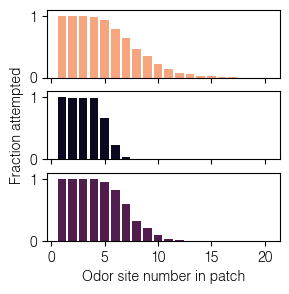

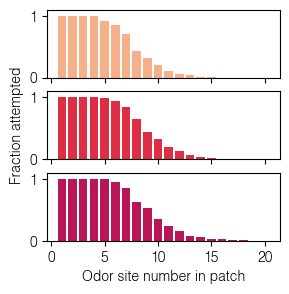

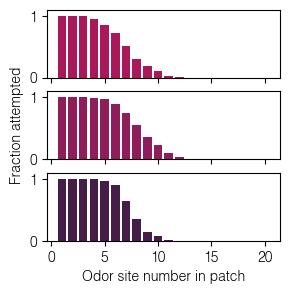

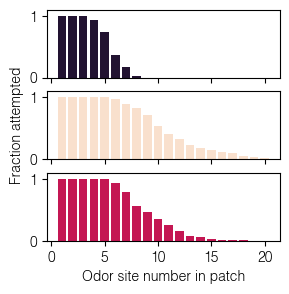

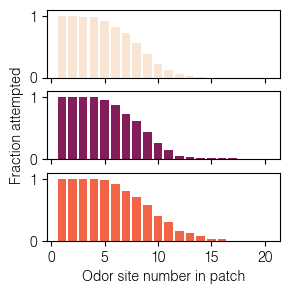

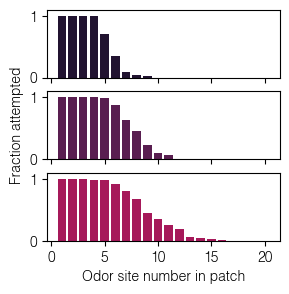

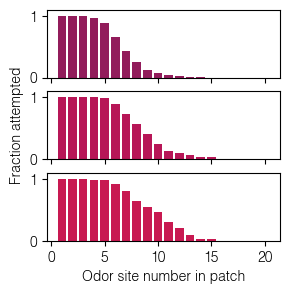

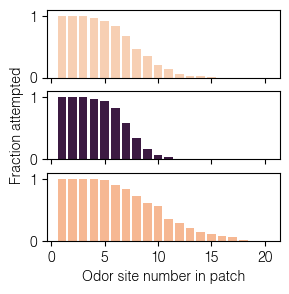

In [162]:
plot_avg_stops_vs_reward_param([
    '../../results/rl_agent_outputs/he_init_vanilla_indep_test_one_and_half_reward_2025-07-31_22_06_50_177070_var_noise_0.0_activity_weight_1/state',
], update_num=None, max_reward_param=30, max_reward_sites=20, model_colors=None)

In [166]:
def compute_patch_statistics(b_data, max_reward_sites=30):
    
    rewards_at_positions = b_data['rewards_at_positions']
    reward_attempted_at_positions = b_data['reward_attempted_at_positions']
    all_patch_nums = b_data['current_patch_num']
    all_patch_reward_params = b_data['patch_reward_param']
    
    reward_param_of_stop = []
    site_idx_of_stop =  []
    site_stops_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1, max_reward_sites))
    patches_entered_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1,))
    reward_param_for_patch_type = np.zeros((np.array(all_patch_nums).max() + 1,))
    
    last_pstart = None
    last_reward_site_start = None
    patch_count = 0
    for i, pstart in enumerate(b_data['current_patch_start']):
        # print(f'Step {i}')
        if last_pstart is None or (pstart != last_pstart).any():
            patches_entered_for_patch_type[all_patch_nums[i]] += 1
            reward_param_for_patch_type[all_patch_nums[i]] = all_patch_reward_params[i]
            patch_count += 1
            pb = [pstart, pstart]
            rw_site_counter = 0
        
        rwsb = copy(b_data['reward_bounds'][i])
        reward_site_start = int(rwsb[0])
        # print('rwsite_start', reward_site_start)
        # print('last_rwsite_start', last_reward_site_start)
        if last_reward_site_start is None or last_reward_site_start != reward_site_start:
            if np.sum(reward_attempted_at_positions[int(rwsb[0]):int(rwsb[1])]) == 0:
                pb[1] = rwsb[1]
            else:
                reward_param_of_stop.append(b_data['patch_reward_param'][i])
                site_idx_of_stop.append(rw_site_counter)
                if rw_site_counter < max_reward_sites:
                    site_stops_for_patch_type[all_patch_nums[i], rw_site_counter] += 1
                rw_site_counter += 1

        last_pstart = pstart
        last_reward_site_start = reward_site_start

    avg_stops_for_patch_type = np.empty((site_stops_for_patch_type.shape[0],))
    x = np.arange(1, site_stops_for_patch_type.shape[1] + 1)
    
    for k in range(site_stops_for_patch_type.shape[0]):
        cdf = site_stops_for_patch_type[k, :] / patches_entered_for_patch_type[k]
        pdf = cdf - np.concatenate([cdf[1:], np.zeros(1)])
        avg_stops_for_patch_type[k] = np.dot(pdf, x)

    return {
        'site_stops_for_patch_type': site_stops_for_patch_type,
        'patches_entered_for_patch_type': patches_entered_for_patch_type,
        'reward_param_for_patch_type': reward_param_for_patch_type,
        'avg_stops_for_patch_type': avg_stops_for_patch_type,
        'unique_patch_reward_params': b_data['unique_patch_reward_params'],
    }
    

In [173]:
def plot_avg_stops_vs_reward_param_combined(data_paths, update_num=None, max_reward_sites=30, xticks=None):

    scale = 1
    fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 3 * scale), sharex=True, sharey=True)

    for idx_data_path, data_path in enumerate(data_paths):

        d = load_behavioral_data(data_path, update_num).__next__()
    
        for env_idx in range(30):
            b_data = parse_behavioral_data(d, env_idx)
            stats = compute_patch_statistics(b_data, max_reward_sites=max_reward_sites)
            avg_stops_for_patch_type = stats['avg_stops_for_patch_type']
            
            axs.scatter(stats['unique_patch_reward_params'], avg_stops_for_patch_type, marker='+', color='black', s=30, alpha=1)
    axs.set_ylabel('Avg stops for patch type')
    axs.set_xlabel(r'$\tau$')
    if xticks is not None:
        axs.set_xticks(xticks)
    format_plot(axs, axislabelsize=14, ticklabelsize=14)

### Analysis of networks trained on environment in which reward parameters is sampled from $U\left[0, 30\right]$ each session

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
00007.pkl


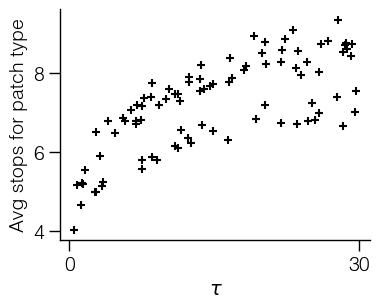

In [174]:
plot_avg_stops_vs_reward_param_combined([
    '../../results/rl_agent_outputs/he_init_vanilla_indep_test_2025-07-31_17_28_09_615835_var_noise_0.0_activity_weight_1/state',
], update_num=None, max_reward_sites=30, xticks=[0, 30])

These networks stop more on average for larger reward parameter patches.

In [184]:
def plot_avg_stops_given_env(data_paths, update_num=None, max_reward_sites=30, xticks=None):

    scale = 1
    fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 3 * scale), sharex=True, sharey=True)

    for idx_data_path, data_path in enumerate(data_paths):

        for d in load_behavioral_data(data_path, update_num, all=True): 
            for env_idx in range(30):
                b_data = parse_behavioral_data(d, env_idx)
                stats = compute_patch_statistics(b_data, max_reward_sites=max_reward_sites)
                avg_stops_for_patch_type = stats['avg_stops_for_patch_type']
                reward_params = stats['unique_patch_reward_params']
                
                axs.scatter(stats['unique_patch_reward_params'].mean(), avg_stops_for_patch_type.mean(), marker='+', color='black', s=30, alpha=0.3)
    axs.set_ylabel(r'Avg stops per patch')
    axs.set_xlabel(r'Average $\tau$ of environment')
    if xticks is not None:
        axs.set_xticks(xticks)
    format_plot(axs, axislabelsize=14, ticklabelsize=14)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
00000.pkl
00001.pkl
00002.pkl
00003.pkl
00004.pkl
00005.pkl
00006.pkl
00007.pkl


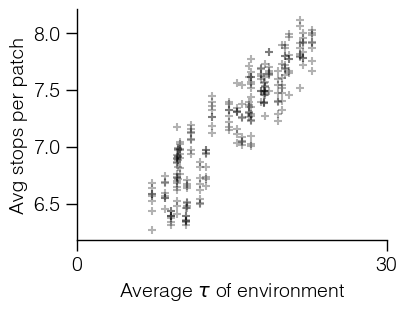

In [185]:
plot_avg_stops_given_env([
    '../../results/rl_agent_outputs/he_init_vanilla_indep_test_2025-07-31_17_28_09_615835_var_noise_0.0_activity_weight_1/state',
], update_num=None, max_reward_sites=30, xticks=[0, 30])

The average reward parameter of the environment regulates the average number of times the agent stops per patch.

In [213]:
def plot_avg_stops_for_fixed_reward_param_given_third(data_paths, update_num=None, max_reward_sites=30, xticks=None, fixed_param=5, xlabel=None):

    scale = 1
    fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 3 * scale), sharex=True, sharey=True)

    for idx_data_path, data_path in enumerate(data_paths):

        for d in load_behavioral_data(data_path, update_num, all=True): 
            for env_idx in range(30):
                b_data = parse_behavioral_data(d, env_idx)
                stats = compute_patch_statistics(b_data, max_reward_sites=max_reward_sites)
                avg_stops_for_patch_type = stats['avg_stops_for_patch_type']
                reward_params = stats['unique_patch_reward_params']
                
                axs.scatter(stats['unique_patch_reward_params'][2], avg_stops_for_patch_type[0], marker='+', color='black', s=30, alpha=0.3)
    axs.set_ylabel('Avg stops for fixed\n' + r'reward param ($\tau =$' + f' {fixed_param})')
    if xlabel is None:
        axs.set_xlabel(r'$\tau$ of third patch')
    else:
        axs.set_xlabel(xlabel)
    if xticks is not None:
        axs.set_xticks(xticks)
    format_plot(axs, axislabelsize=14, ticklabelsize=14)

To see whether this agent tracks a global reward rate, we can see if the number of stops at a patch of fixed reward param varies on the basis of the value of the other two patches.

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
00000.pkl
00001.pkl
00002.pkl
00003.pkl
00004.pkl
00005.pkl
00006.pkl
00007.pkl


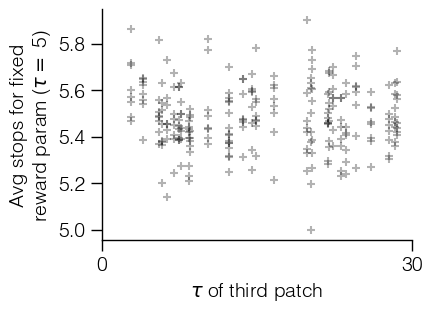

In [214]:
plot_avg_stops_for_fixed_reward_param_given_third([
    '../../results/rl_agent_outputs/he_init_vanilla_indep_test_first_two_patch_param_5_2025-08-01_10_43_44_658950_var_noise_0.0_activity_weight_1/state',
], update_num=None, max_reward_sites=30, xticks=[0, 30])

When 2 patches are fixed to $\tau = 5$ and the third is varied, agents' behavior in one of $\tau = 5$ patches does not seem to correlate with the value of the third patch.

In [215]:
def plot_avg_stops_for_fixed_reward_param_given_env(data_paths, update_num=None, max_reward_sites=30, xticks=None, fixed_param=5, xlabel=None):

    scale = 1
    fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 3 * scale), sharex=True, sharey=True)

    for idx_data_path, data_path in enumerate(data_paths):

        for d in load_behavioral_data(data_path, update_num, all=True): 
            for env_idx in range(30):
                b_data = parse_behavioral_data(d, env_idx)
                stats = compute_patch_statistics(b_data, max_reward_sites=max_reward_sites)
                avg_stops_for_patch_type = stats['avg_stops_for_patch_type']
                reward_params = stats['unique_patch_reward_params']
                
                axs.scatter(stats['unique_patch_reward_params'][2], avg_stops_for_patch_type[0], marker='+', color='black', s=30, alpha=0.3)
    axs.set_ylabel('Avg stops for fixed\n' + r'reward param ($\tau =$' + f' {fixed_param})')
    if xlabel is None:
        axs.set_xlabel(r'Avg $\tau$ of environment')
    else:
        axs.set_xlabel(xlabel)
    if xticks is not None:
        axs.set_xticks(xticks)
    format_plot(axs, axislabelsize=14, ticklabelsize=14)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
00000.pkl
00001.pkl
00002.pkl
00003.pkl
00004.pkl
00005.pkl
00006.pkl
00007.pkl


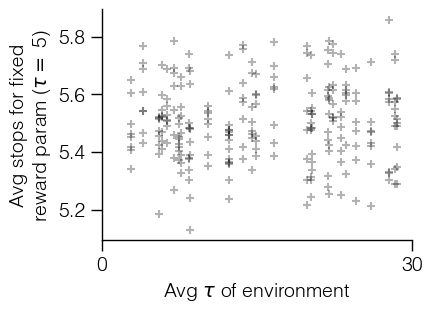

In [216]:
plot_avg_stops_for_fixed_reward_param_given_env([
    '../../results/rl_agent_outputs/he_init_vanilla_indep_test_first_patch_param_5_2025-08-01_08_11_32_863923_var_noise_0.0_activity_weight_1/state',
], update_num=None, max_reward_sites=30, xticks=[0, 30])

When just a single patch is fixed, behavior in the fixed patch does not correlate with avg $\tau$ in env.

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
00000.pkl
00001.pkl
00002.pkl
00003.pkl
00004.pkl
00005.pkl
00006.pkl
00007.pkl


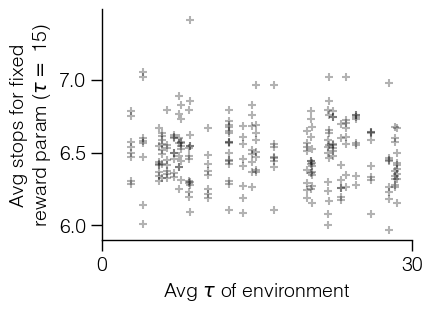

In [217]:
plot_avg_stops_for_fixed_reward_param_given_env([
    '../../results/rl_agent_outputs/he_init_vanilla_indep_test_first_patch_param_15_2025-08-01_10_23_20_084860_var_noise_0.0_activity_weight_1/state',
], update_num=None, max_reward_sites=30, xticks=[0, 30], fixed_param=15, xlabel=r'Avg $\tau$ of environment')

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
00007.pkl
[ 5.         11.42245469 19.89143716]
[ 5.         28.743167   23.10938797]
[ 5.         11.18133465 16.65386334]
[ 5.         13.49926263 12.32822409]
[ 5.         23.40301382  2.78111266]
[5.         9.25048821 6.94461135]
[ 5.         18.04842637 28.56542002]
[ 5.         13.92294523  5.78385087]
[ 5.         25.7912354  28.32598907]
[ 5.         23.93697064 24.6120564 ]
[ 5.          1.6609812  23.65604632]
[ 5.          1.38287462 20.30448723]
[ 5.         28.52142919 21.95981825]
[ 5.         18.27199618  4.00172893]
[ 5.          3.14388313 22.33921445]
[ 5.         16.48634181  8.44341906]
[ 5.         19.04501118  7.47129275]
[ 5.         29.23449283 21.86203901]
[ 5.         26.74719802  8.54583502]
[ 5.          7.41185496 27.79005405]


C:\Users\david.bell\AppData\Local\Temp\ipykernel_20824\163301953.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3, 1, figsize=(3 * scale, 3 * scale), sharex=True, sharey=True)


[5.         6.84249313 7.66421771]
[ 5.          1.34136547 10.29911018]
[5.         0.78353945 6.3231192 ]
[ 5.         16.83496621 13.64626207]
[ 5.         10.89718491  5.54630063]
[ 5.         29.1496776  14.51579941]
[ 5.         10.00236798 20.21104874]
[ 5.          6.91431299 12.33183212]
[ 5.         13.53617748 14.88181046]
[ 5.          4.73611742 26.0074523 ]


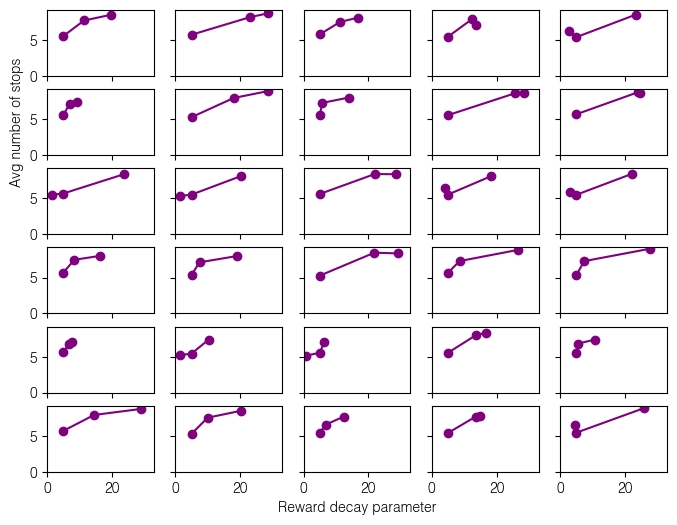

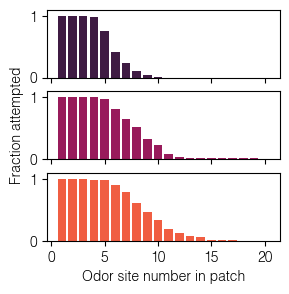

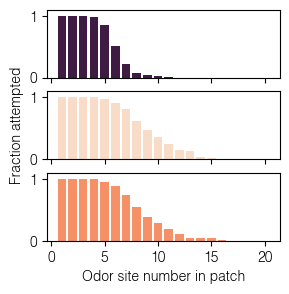

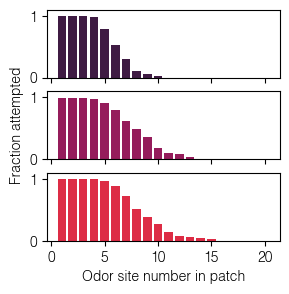

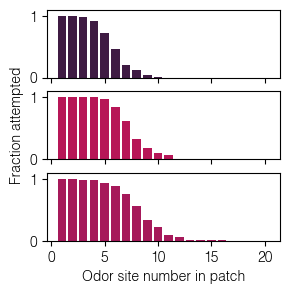

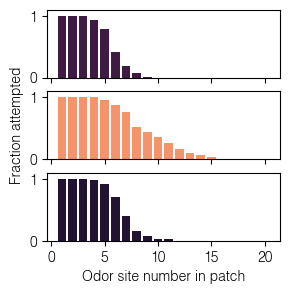

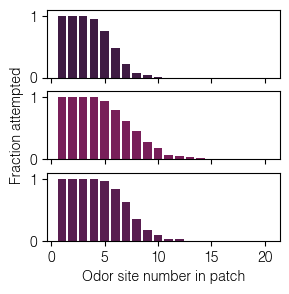

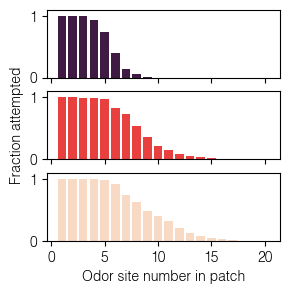

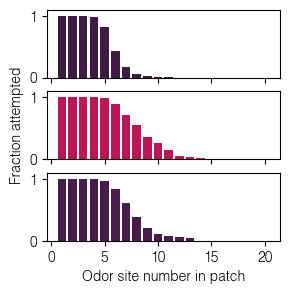

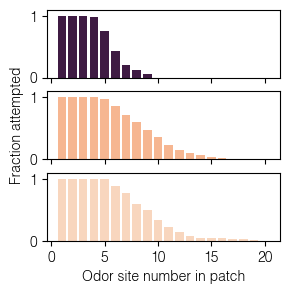

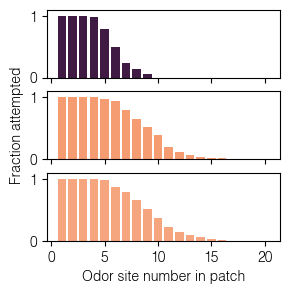

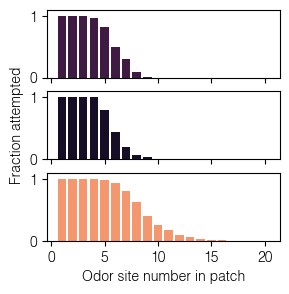

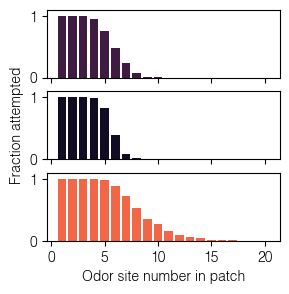

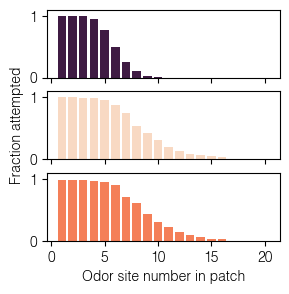

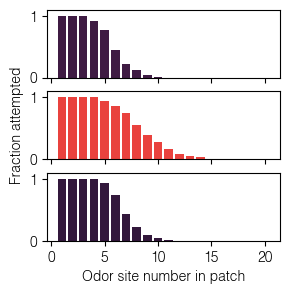

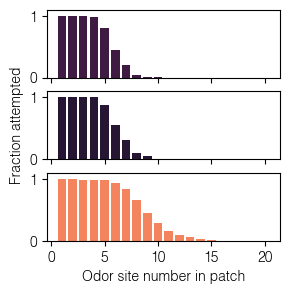

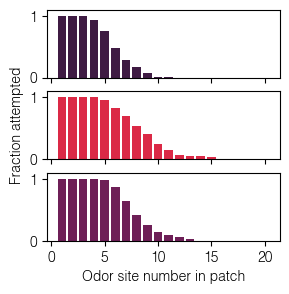

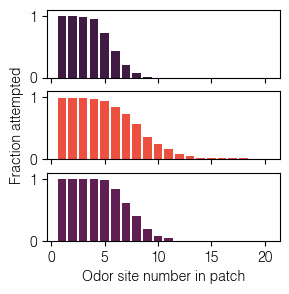

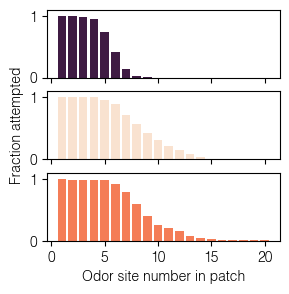

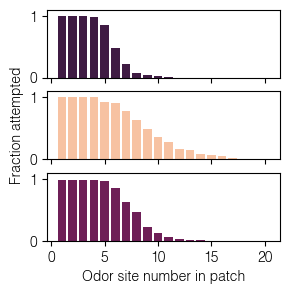

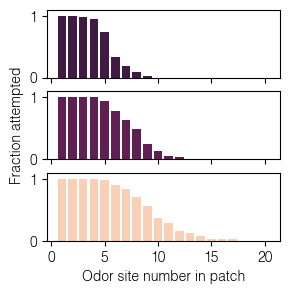

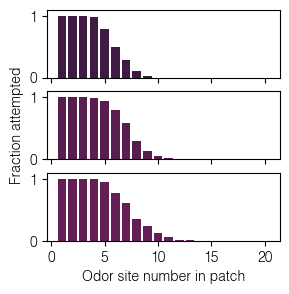

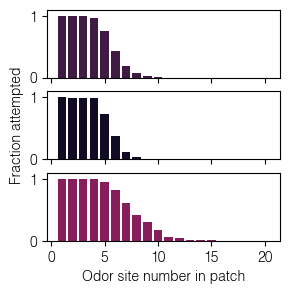

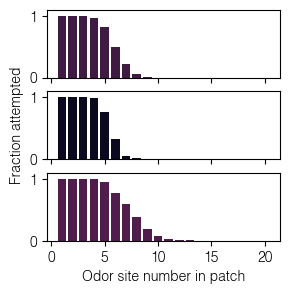

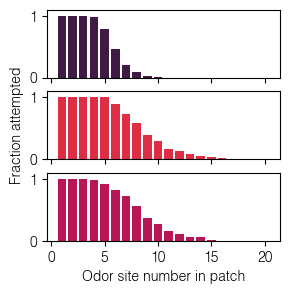

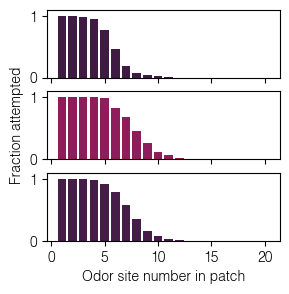

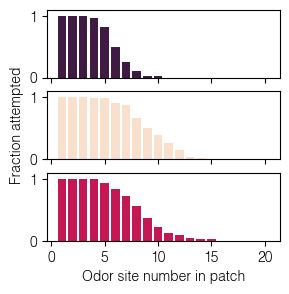

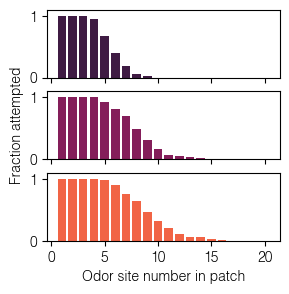

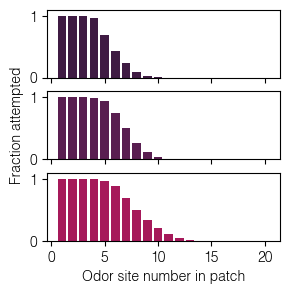

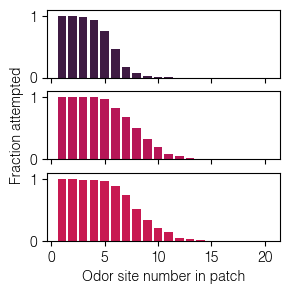

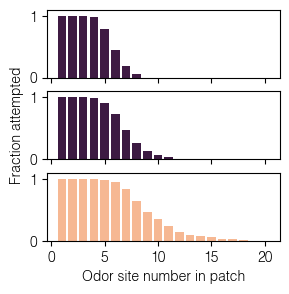

In [165]:
plot_avg_stops_vs_reward_param([
    '../../results/rl_agent_outputs/he_init_vanilla_indep_test_first_patch_param_5_2025-08-01_08_11_32_863923_var_noise_0.0_activity_weight_1/state',
], update_num=None, max_reward_param=30, max_reward_sites=20, model_colors=None)

In [164]:
def plot_avg_stops_across_conditions(data_paths, update_num=None, max_reward_sites=30, xticks=None):

    scale = 1
    fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 3 * scale), sharex=True, sharey=True)

    for idx_data_path, data_path in enumerate(data_paths):

        d = load_behavioral_data(data_path, update_num).__next__()
    
        for env_idx in range(30):
            b_data = parse_behavioral_data(d, env_idx)
            stats = compute_patch_statistics(b_data, max_reward_sites=max_reward_sites)
            avg_stops_for_patch_type = stats['avg_stops_for_patch_type']
            if xticks is not None:
                x = xticks[idx_data_path]
            else:
                x = idx_data_path
            
            axs.scatter([x] * len(avg_stops_for_patch_type), avg_stops_for_patch_type, marker='+', color='black', s=30, alpha=0.3)
    axs.set_ylabel('Avg stops for patch type')
    axs.set_xlabel('Reward size')
    if xticks is not None:
        axs.set_xticks(xticks)
    format_plot(axs, axislabelsize=14, ticklabelsize=14)

For agent trained in environment in which reward parameters are drawn from a uniform distribution like

$$ \tau \sim U\left[0, 30\right],$$

plot the average number of stops across all patches for 30 environements while changing the size of reward. The logic is that if an agent is reward counting, a smaller reward magnitude should lead to a later leave time. Conversely, if the agent tends to dwell longer with more rewards, this should lead to more stops per patch on average.

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
00007.pkl
['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
00007.pkl
['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
00007.pkl
['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']
00007.pkl


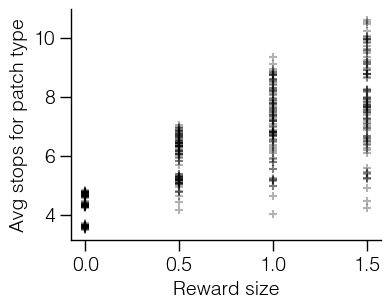

In [179]:
plot_avg_stops_across_conditions([
    '../../results/rl_agent_outputs/he_init_vanilla_indep_test_zero_reward_2025-08-01_07_24_16_928959_var_noise_0.0_activity_weight_1/state',
    '../../results/rl_agent_outputs/he_init_vanilla_indep_test_half_reward_2025-07-31_18_04_52_934603_var_noise_0.0_activity_weight_1/state',
    '../../results/rl_agent_outputs/he_init_vanilla_indep_test_2025-07-31_17_28_09_615835_var_noise_0.0_activity_weight_1/state',
    '../../results/rl_agent_outputs/he_init_vanilla_indep_test_one_and_half_reward_2025-07-31_22_06_50_177070_var_noise_0.0_activity_weight_1/state',
], update_num=None, max_reward_sites=30, xticks=[0, 0.5, 1, 1.5])

['00000.pkl', '00001.pkl', '00002.pkl']
00002.pkl
['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl']
00005.pkl


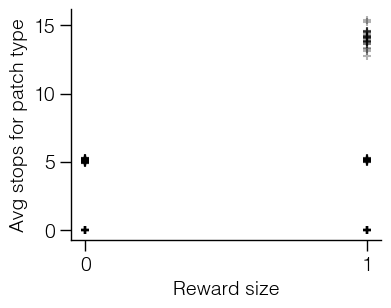

In [168]:
plot_avg_stops_across_conditions([
    '../../results/rl_agent_outputs/he_init_vanilla_fixed_813001_rw_size_0_test_2025-08-07_10_48_44_044427_var_noise_0.0_activity_weight_1/state',
    '../../results/rl_agent_outputs/he_init_vanilla_fixed_813001_rw_size_1_test_2025-08-07_10_45_13_260304_var_noise_0.0_activity_weight_1/state',
], update_num=None, max_reward_sites=30, xticks=[0, 1])